In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Add, Activation
from tensorflow.keras.models import Model, load_model

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Keras Function API Advanced
In this notebook we are going to go over crazy Functional API stuff and custom functions. For this example we will borrow Mnist again.

Load Mnist

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_images.shape, test_images.shape

((60000, 784), (10000, 784))

In [3]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_labels.shape, test_labels.shape

((60000, 10), (10000, 10))

# Multiple Inputs/Outputs
So at this point I am going to say the custom functions I make won't make a lot of sense to solve Mnist better but they are a good example.

For example I want to show how to handle multiple inputs. Thus I need two different input tensors for my model. Usually this would be different kinds of data like images and sequence data. However, for this example I am going to take the flattened Mnist imagest and split them down the middle into two different dense inputs.

In [4]:
middle = int(28 * 28 // 2)
train_images1 = train_images[...,:middle]
train_images2 = train_images[...,middle:]

test_images1 = test_images[..., :middle]
test_images2 = test_images[..., middle:]

Now we can build a model that had two different inputs and outputs. Since the data is the same I will do the same thing with each input which is put them through some dense layers.

In [5]:
input_tensor1 = Input(shape=(middle,), name='input1')
current_tensor1 = input_tensor1
current_tensor1 = Dense(units=32, activation='relu')(current_tensor1)
current_tensor1 = Dense(units=32, activation='relu')(current_tensor1)
output_tensor1 = current_tensor1


input_tensor2 = Input(shape=(middle,), name='input2')
current_tensor2 = input_tensor2
current_tensor2 = Dense(units=32, activation='relu')(current_tensor2)
current_tensor2 = Dense(units=32, activation='relu')(current_tensor2)
output_tensor2 = current_tensor2

Now I need to combine the transformed versions of each of those tensors. In this case I decided to use an Add merge layer. Again since this problem is made up do not look too far into why I picked an Add merge layer.

In [6]:
current_tensor = Add()([output_tensor1, output_tensor2])
current_tensor = Dense(units=10, activation='linear')(current_tensor)

Finally I also wanted to have different outputs. However I am not sure what the different outputs would be, so I am just going to apply a slightly different activation function to the output and call it a new output

In [7]:
output_tensor = Activation(activation='softmax', name='output1')(current_tensor)

output_tensor_squared = Activation(activation=lambda x:x**2, name='output2')(current_tensor)

Finally we need to put this all into one model. I need to remember the names I gave to the original inputs and the final outputs to make my model

In [8]:
model = Model([input_tensor1, input_tensor2], [output_tensor, output_tensor_squared])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 392)]        0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 392)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           12576       ['input1[0][0]']                 
                                                                                                  
 dense_2 (Dense)                (None, 32)           12576       ['input2[0][0]']                 
                                                                                              

this summary is hard to see so lets make a picture

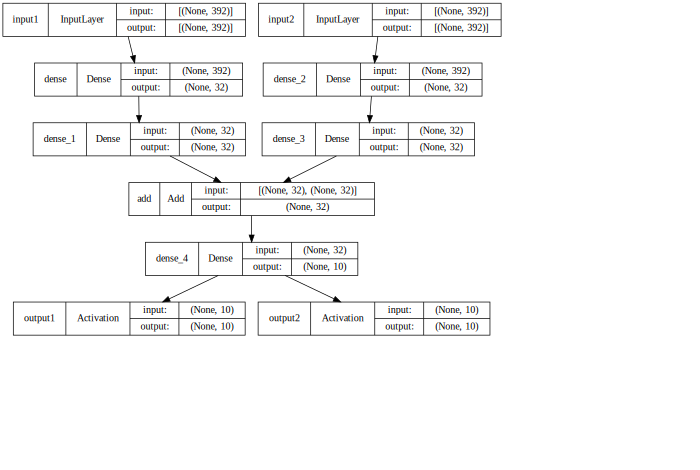

In [9]:
SVG(model_to_dot(model, show_shapes=True, dpi=100).create(prog='dot', format='svg'))

And now we can train this model. Note the difference in the fit for `x` and `validation_data`. I now need to input a list of numpy arrays so that I can match them to each of the inputs and outputs I made in my original model.

Also since I have two outputs I give a loss for each. In this case I picked `categorical_crossentropy` for the softmax output and `mse` for the squared output.

Interestingly our our metrics are applied ot all the outputs regardless of how many metrics we use or how many outputs there were

In [10]:
model.compile(loss=['categorical_crossentropy', 'mse'],  
              loss_weights = [2.0, 0.5],
              metrics=['acc'], 
              optimizer='rmsprop')

model.fit(x=[train_images1, train_images2], 
          y=[train_labels, train_labels],
          epochs=5, 
          validation_data=([test_images1, test_images2], [test_labels, test_labels])
)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2087 - output1_loss: 0.9178 - output2_loss: 0.7462 - output1_acc: 0.9057 - output2_acc: 0.8033 - val_loss: 1.9231 - val_output1_loss: 0.7751 - val_output2_loss: 0.7459 - val_output1_acc: 0.9483 - val_output2_acc: 0.8802
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.8810 - output1_loss: 0.7402 - output2_loss: 0.8014 - output1_acc: 0.9538 - output2_acc: 0.8922 - val_loss: 1.8227 - val_output1_loss: 0.7082 - val_output2_loss: 0.8125 - val_output1_acc: 0.9593 - val_output2_acc: 0.9114
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.8107 - output1_loss: 0.7041 - output2_loss: 0.8050 - output1_acc: 0.9593 - output2_acc: 0.9094 - val_loss: 1.8078 - val_output1_loss: 0.6961 - val_output2_loss: 0.8313 - val_output1_acc: 0.9574 - val_output2_acc: 0.9077
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7760 - output1_loss: 0.6866 - ou

See how we now get a loss value for each output loss and an accuracy. The losses correspond to the loss functions we picked but the metrics were applied to all the outputs. Also notice that we have two validation outputs for loss and metrics as well.

## Dict Syntax
There is also a dictionary syntax where you can name all the tensors. This may make it easier later to remember which tensor is which but it can also take more lines.

**WARNING**
I needed to name each of the tensors when I made them using the `name` argument for the layer when I created the input tensors and the output tensors. This then matched the key in the dictionaries. This was not what I expected and was counterintuitive so remember to do this if you make your input/output with dicts.


In [11]:
input_dict = {
    'input1': input_tensor1,
    'input2': input_tensor2
}
output_dict = {
    'output1': output_tensor,
    'output2': output_tensor_squared
}
model_dict = Model(input_dict, output_dict)
model_dict.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 392)]        0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 392)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           12576       ['input1[0][0]']                 
                                                                                                  
 dense_2 (Dense)                (None, 32)           12576       ['input2[0][0]']                 
                                                                                            

Once again a picture is worth a thousand words.

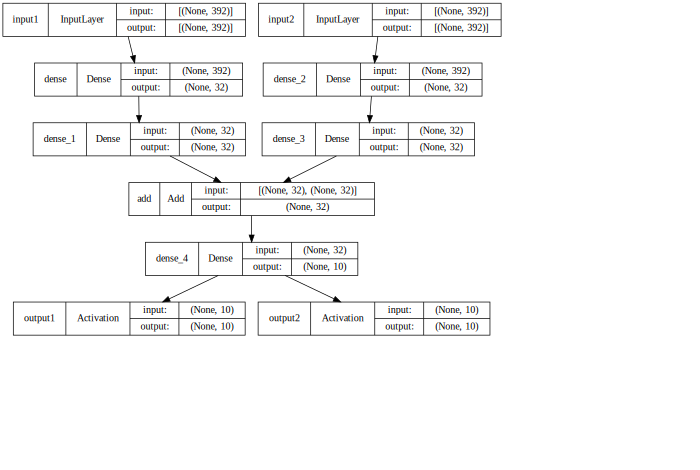

In [12]:
SVG(model_to_dot(model_dict, show_shapes=True, dpi=100).create(prog='dot', format='svg'))

Compiling with the dict model has a slightly different syntax. Note that this is getting longer compared to before but we can do things we could not do before. For example we can decide explicitly which output the loss functions and metrics apply to. Note that I only use accuracy on the softmax output because that is the one that actually makes sense for accuracy.

In [13]:
# Dict for the compile
loss_dict = {
    'output1': 'categorical_crossentropy',
    'output2': 'mse'
}
loss_weights_dict = {
    'output1': 2.0,
    'output2': 0.5
}
metrics_dict = {
     'output1': 'acc'
}
model_dict.compile(loss=loss_dict,  
              loss_weights = loss_weights_dict,
              metrics=metrics_dict, 
              optimizer='rmsprop')

After compiling I can also use the dict syntax to call out which numpy arrays correspond to which tensors when fitting.

In [14]:
# dicts for fitting
x_dict = {
    'input1': train_images1,
    'input2': train_images2,
}
y_dict = {
    'output1': train_labels,
    'output2': train_labels
}
x_dict_test = {
    'input1': test_images1,
    'input2': test_images2,
}
y_dict_test = {
    'output1': test_labels,
    'output2': test_labels
}
model_dict.fit(x=x_dict, 
          y=y_dict,
          epochs=5, 
          validation_data=(x_dict_test, y_dict_test)
)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7418 - output1_loss: 0.6690 - output2_loss: 0.8075 - output1_acc: 0.9648 - val_loss: 1.7450 - val_output1_loss: 0.6739 - val_output2_loss: 0.7945 - val_output1_acc: 0.9628
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7306 - output1_loss: 0.6635 - output2_loss: 0.8072 - output1_acc: 0.9657 - val_loss: 1.7333 - val_output1_loss: 0.6742 - val_output2_loss: 0.7699 - val_output1_acc: 0.9631
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7223 - output1_loss: 0.6593 - output2_loss: 0.8073 - output1_acc: 0.9657 - val_loss: 1.7328 - val_output1_loss: 0.6484 - val_output2_loss: 0.8722 - val_output1_acc: 0.9650
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7152 - output1_loss: 0.6556 - output2_loss: 0.8078 - output1_acc: 0.9665 - val_loss: 1.7226 - val_output1_loss: 0.6734 - val_output2_loss: 0.7516 - val_output1_acc: 0.9641
Epoc

Notice now I only get the accuracy of the first output because that is the only output I asked to do the accuracy on. Before I got accuracies on all the outputs becasue Keras did not know how to map the accuracies to the outputs.

# Custom Functions
We can make custom functions for Keras any function we want as long as it has the right arguments and returns the correct variable.

**WARNING** you must use either tensorflow or keras operations on the tensors for this to work. **DO NOT** use the numpy function or else it will not work but might actually compile/run and be very confusing.

Most functions are the same between Keras and tensorflow but sometimes there are functions one has that the other does not. If the function does the same thing it shouldn't matter which you use because keras is probably calling the tensorflow function directly anyway.

### Custom Loss
for custom loss we input two `tf.Tensor` objects for the truth (or the labels aka what we pass to `y` in the fit function) and the prediction (the output of our ANN)

We must return a `tf.Tensor` object of the same shape besides the last dimension which must now be one. Remember this always operates on a batch. So if our shapes are for `y_true.shape=(32, 10)` and `y_pred.shape=(32, 10)` we should output a tensor `loss.shape=(32,1)`

I will now make my own custom loss which just takes an average across the two tensors multiplied together. This is just something I made up so do not look into it too much.

In [15]:
def my_custom_loss_fn(y_true, y_pred):
    # I will multiply the two functions then sum along the last axis
    # Note that I had to use the tensorflow function and could not use the numpy function
    loss = -tf.reduce_mean(y_true * y_pred, axis=-1)
    return loss

# now I can call my new function on some dummy tensors to test
y_true_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
y_pred_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
res = my_custom_loss_fn(y_true_t, y_pred_t)
res.numpy()

array([ -2.5, -12.5], dtype=float32)

Since we have to make our loss function have two input you may be asking "How would I give my own arguments to the function?". Well do not worry there is a solution for that with the `functools` package (installed by default with python). We are going to use the partial function to preset arguments so that Keras only sees the two it cares about.

In [16]:
from functools import partial

def my_custom_loss_fn_with_args(y_true, y_pred, arg1, arg2):
    if arg1 > 1:
        loss = -tf.reduce_mean(y_true * y_pred, axis=-1)
    else:
        loss = tf.reduce_mean(y_true + y_pred, axis=-1)
    loss *= arg2
    return loss

# make some input tensors
y_true_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
y_pred_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
print('Try the function without the arguments and it will fail')
try:
    my_custom_loss_fn_with_args(y_true_t, y_pred_t)
except Exception as e:
    print(e)

# preset the arguments with the partial function  
my_custom_loss_fn_with_build_in_args = partial(my_custom_loss_fn_with_args,
                                              arg1=10,
                                              arg2=3)

print('\nNow with the preset arguments it works as expected')
# now I can call my new function without arg1 or arg2 set
res = my_custom_loss_fn_with_build_in_args(y_true_t, y_pred_t)
res.numpy()

Try the function without the arguments and it will fail
my_custom_loss_fn_with_args() missing 2 required positional arguments: 'arg1' and 'arg2'

Now with the preset arguments it works as expected


array([ -7.5, -37.5], dtype=float32)

You can also nest functions to get the same effect. This may be more intuitive compare to the `functools` approach above

In [17]:
def make_my_custom_loss_fn_with_args(arg1, arg2):
    def my_custom_loss_fn_with_args(y_true, y_pred):
        if arg1 > 1:
            loss = -tf.reduce_mean(y_true * y_pred, axis=-1)
        else:
            loss = tf.reduce_mean(y_true + y_pred, axis=-1)
        loss *= arg2
        return loss
    return my_custom_loss_fn_with_args

# make some input tensors
y_true_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
y_pred_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])

# now build the actual function with our args
my_custom_loss_fn_with_build_in_args =  make_my_custom_loss_fn_with_args(arg1=10, arg2=3)


print('\nNow with the built in arguments it works as expected')
# now I can call my new function without arg1 or arg2 set
res = my_custom_loss_fn_with_build_in_args(y_true_t, y_pred_t)
res.numpy()


Now with the built in arguments it works as expected


array([ -7.5, -37.5], dtype=float32)

### Custom Activation
Custom Activation functions simply take in some tensor `x` and return another tensor of the same shape. For example I will make an activation that squares the tensor

In [18]:
def my_custom_activation_fn(x):
    ## I could return x**2 but I want to emphasize that we can use keras backend functions
    return K.square(x)

x_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
res = my_custom_activation_fn(x_t)
res.numpy()

array([[ 1.,  4.],
       [ 9., 16.]], dtype=float32)

### Custom Metric
A custom metric looks just like a custom loss function. I am going to repeat my loss function but use the Keras backend instead of the tensorflow function

In [19]:
def my_custom_metric_fn(y_true, y_pred):
    # I will multiply the two functions then sum along the last axis
    # Note that I had to use the keras backend function and could not use the numpy function
    loss = -K.mean(y_true * y_pred, axis=-1)
    return loss

y_true_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
y_pred_t = tf.constant([[1.0, 2.0], [3.0, 4.0]])
res = my_custom_metric_fn(y_true_t, y_pred_t)
res.numpy()

array([ -2.5, -12.5], dtype=float32)

Now lets use these in a model. We are going to make a simple network for now

In [20]:
input_tensor = Input(shape=(middle,))
current_tensor = input_tensor
current_tensor = Dense(units=32, activation='relu')(current_tensor)
# note here I used a custom activation function
current_tensor = Dense(units=32, activation=my_custom_activation_fn)(current_tensor)
current_tensor = Dense(units=10, activation='softmax')(current_tensor)
output_tensor = current_tensor

model = Model(input_tensor, output_tensor)

# here I use my custom loss and custom metric
model.compile(loss=my_custom_loss_fn,  
              metrics=[my_custom_metric_fn], 
              optimizer='rmsprop')

model.fit(x=train_images1, 
          y=train_labels,
          epochs=5, 
          validation_data=(test_images1, test_labels)
)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: -0.0665 - my_custom_metric_fn: -0.0665 - val_loss: -0.0711 - val_my_custom_metric_fn: -0.0711
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: -0.0715 - my_custom_metric_fn: -0.0715 - val_loss: -0.0719 - val_my_custom_metric_fn: -0.0719
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: -0.0726 - my_custom_metric_fn: -0.0726 - val_loss: -0.0730 - val_my_custom_metric_fn: -0.0730
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: -0.0732 - my_custom_metric_fn: -0.0732 - val_loss: -0.0736 - val_my_custom_metric_fn: -0.0736
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: -0.0735 - my_custom_metric_fn: -0.0735 - val_loss: -0.0742 - val_my_custom_metric_fn: -0.0742


If you were to save this model with `model.save('model.h5')` then using the `load_model` to load becomes more complicated because you have your own functions now. Before Keras knew any function you used because they were built in. However since Keras saves the names of the functions but the definition you need to supply the definition or else Keras will not know what to do.

To supply the definition for a function we need to use the `custom_objects` dict argument to the `load_model` function

In [21]:
model.save('custom_model.h5')

try:
    model_loaded = load_model('custom_model.h5')
except:
    print("Failed to load model without the custom_objects dict")
    
custom_objects = {
    'my_custom_activation_fn': my_custom_activation_fn,
    'my_custom_loss_fn': my_custom_loss_fn,
    'my_custom_metric_fn': my_custom_metric_fn,
}
model_loaded = load_model('custom_model.h5', custom_objects=custom_objects)
print("\nLoaded model with custom_objects:")
model_loaded.summary()

Failed to load model without the custom_objects dict

Loaded model with custom_objects:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 392)]             0         
                                                                 
 dense_5 (Dense)             (None, 32)                12576     
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 13,962
Trainable params: 13,962
Non-trainable params: 0
_________________________________________________________________


# Other Custom Keras Code
## Custom Callbacks
You can make your own callbacks. Your callback can do something at the start or end of either training, epochs or batches.

In [22]:
from tensorflow.keras.callbacks import LambdaCallback

def on_epoch_end_custom(epoch, logs=None):
    print(f'epoch number {epoch} ended')
    print(f'logs:{logs}\n')
    
my_callback = LambdaCallback(on_epoch_end=on_epoch_end_custom)

And use it in fitting

In [23]:
model.fit(x=train_images1, 
          y=train_labels,
          epochs=5, 
          validation_data=(test_images1, test_labels),
          verbose=0,
          callbacks=[my_callback]
)

epoch number 0 ended
logs:{'loss': -0.07389189302921295, 'my_custom_metric_fn': -0.07389189302921295, 'val_loss': -0.07317245751619339, 'val_my_custom_metric_fn': -0.07317245751619339}

epoch number 1 ended
logs:{'loss': -0.07409676909446716, 'my_custom_metric_fn': -0.07409676909446716, 'val_loss': -0.07429993152618408, 'val_my_custom_metric_fn': -0.07429993152618408}

epoch number 2 ended
logs:{'loss': -0.07432261854410172, 'my_custom_metric_fn': -0.07432261854410172, 'val_loss': -0.07480642944574356, 'val_my_custom_metric_fn': -0.07480642944574356}

epoch number 3 ended
logs:{'loss': -0.0745009183883667, 'my_custom_metric_fn': -0.0745009183883667, 'val_loss': -0.07404427230358124, 'val_my_custom_metric_fn': -0.07404427230358124}

epoch number 4 ended
logs:{'loss': -0.07462943345308304, 'my_custom_metric_fn': -0.07462943345308304, 'val_loss': -0.0748521089553833, 'val_my_custom_metric_fn': -0.0748521089553833}



You can also inherit from the `Callback` class if you have a more complicated callback that can save information between calls.

In [24]:
from tensorflow.keras.callbacks import Callback
class MyCallback(Callback):
    def __init__(self, savethis):
        super().__init__()
        self.savethis = savethis
   
    def on_epoch_end(self, epoch, logs=None):
        self.savethis *= 3
        print(f'epoch number {epoch} ended. savethis={self.savethis}')

Also use this callback in fitting

In [25]:
my_callback = MyCallback(2)
model.fit(x=train_images1, 
          y=train_labels,
          epochs=5, 
          validation_data=(test_images1, test_labels),
          verbose=0,
          callbacks=[my_callback]
)

epoch number 0 ended. savethis=6
epoch number 1 ended. savethis=18
epoch number 2 ended. savethis=54
epoch number 3 ended. savethis=162
epoch number 4 ended. savethis=486


You can look up all the other function arguments for the different types 

## Custom Layers
You can make your own layer to do whatever math operations you want. To do this you have to learn some of the syntax that keras expects out of layers like how your layer changes the size and how it expects to be saved etc.
If you really want to inherit from `Layer` see this [link](https://keras.io/layers/writing-your-own-keras-layers/) Example from the link:

In [26]:
# from the page https://keras.io/layers/writing-your-own-keras-layers/
from tensorflow.keras.layers import Layer

class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    # I added this function to show what you would need to do to 
    # save/load the layer via `model.save()` and `load_model`
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
        }
        base_config = super().get_config()
        return {**base_config, **config}
    
# I added this to exercise the layer
my_custom_layer = MyLayer(5)

current_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])

current_tensor = my_custom_layer(current_tensor)
current_tensor

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-0.07307462, -0.10260031,  0.07377756, -0.0295639 , -0.05552077],
       [-0.12197943, -0.24990977,  0.17443089, -0.06223369, -0.11289658]],
      dtype=float32)>

## Lambda Layer
If you do not want to do all that work, you can also use the Lambda Layer which allows you to use a normal function like it was a full layer. This works if you are doing something simple but if you are doing more advanced work it may be better to just make a full layer.

You can also use a function to calculate the output shape if you modify it.

One more thing, the `arguments` argument can be used to give arguments so we do not need the `partial` function from `functools`

In [27]:
from tensorflow.keras.layers import Lambda

def my_custom_layer_function(x, custom_arg):
    return K.square(x) * custom_arg

def my_custom_output_shape(input_shape):
    return input_shape

arguments = {
    'custom_arg': 3,
}

my_custom_layer = Lambda(function=my_custom_layer_function, 
       output_shape=my_custom_output_shape, 
       mask=None, 
       arguments=arguments)

current_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])

current_tensor = my_custom_layer(current_tensor)
current_tensor

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 3., 12.],
       [27., 48.]], dtype=float32)>

## Custom Optimizers
Maybe you think you are a super big brain person and have invented a new optimizer. If so you can make your own and use in in Keras. Once again you need to learn the API keras expects an optimizer to have in order to work seamlessly. I do not advise doing this since the build in ones work fine. I am not even going to write any code for this because I really do not expect anyone to do this

## Other Custom Objects
Model -- Since a Model inherits from Layer making a custom Model will probably look a lot like a custom Layer. Making a custom Model is only necessary if you are doing something really interesting with model specific functions like `fit`, `compile` etc.

Regularizer -- Additions to the loss function like L1 or L2 penalties

Weight Initializer -- New methods to make weigthts like He Initialization

Constraints -- Functions to limit values for weights like MaxNorm